In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple
from tqdm import tqdm

In [2]:
import jax.numpy as jnp
from jax import value_and_grad, jit, random
from jax import Array
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

In [3]:
def init_layer(key, in_dim: int, out_dim: int) -> Tuple[Array, Array]:
    """
    Initialize weight and bias terms for a layer that takes in inputs with
    dimension in_dim and outputs with dimension out_dim.

    in_dim: dimension of the input, i.e. in_features x 1
    out_dim: dimension of the output, i.e. out_features x 1

    Return the weight matrix and bias vector for the layer.

    weight: out_features x in_features
    bias: out_features x 1
    """
    w_key, b_key = random.split(key)
    bound = jnp.sqrt(1 / in_dim)
    weight = random.uniform(w_key, (out_dim, in_dim), minval=-bound, maxval=bound)
    bias = random.uniform(b_key, (out_dim,), minval=-bound, maxval=bound)
    return weight, bias


def init_model(key, sizes: List[int]) -> List[Tuple[Array, Array]]:
    """
    Initialize a model with layer input and output dimentions from sizes.
    When sizes is of length N, the resulting model will contain N-1 layers.

    key: random.PRNGKey(seed), used for randomness in initialization
    sizes: list of integers, where sizes[i] is the in_dim and sizes[i+1] is
        the out_dim for layer i.

    Return a list of tuples, each tuple containing a layer's (weight, bias).
    """
    n = len(sizes)
    key, *layer_keys = random.split(key, num=n)
    model = []
    for i in jnp.arange(n - 1):
        layer = init_layer(layer_keys[i], sizes[i], sizes[i + 1])
        model.append(layer)
    return model


In [4]:
@jit
def sigmoid(x: Array) -> Array:
    """
    Compute the element-wise sigmoid of x.
    """
    return 0.5 * (jnp.tanh(x / 2) + 1)


@jit
def predict(model: List[Tuple[Array, Array]], x: Array) -> Array:
    """
    Return the prediction for x given the model.

    x: input to the model to be predicted
    """
    for weight, bias in model:
        x = sigmoid(jnp.dot(weight, x) + bias)
    return x


In [5]:
@jit
def forward_diffuse(key, x: Array, var_schedule: Array) -> Array:
    """
    Run the forward diffusion process on x for the length of the given
    variance schedule.

    x: input to be diffused
    var_schedule: variance schedule of length t (timesteps)

    Return a sample from the diffused distribution at time t.
    """
    alpha = jnp.prod(1 - var_schedule)
    mean = jnp.sqrt(alpha) * x
    cov = (1 - alpha) * jnp.eye(len(x))
    return random.multivariate_normal(key, mean, cov)


def reverse_diffuse_with(mean_fn: Callable[[Array, int], Array]) -> Callable:
    """
    Return a reverse_diffuse function that uses the given mean_fn
    for determining the mean at each timestep in the reverse process.

    mean_fn: function that takes in (x, t) where
        x: current state
        t: current timestep
    """

    @jit
    def _reverse_diffuse(key, x: Array, var_schedule: Array) -> Array:
        """
        Run the reverse diffusion process on x for the length of the given
        variance schedule.

        x: input to be diffused
        var_schedule: variance schedule of length t (timesteps)

        Return a sample from the reversed distribution at time t.
        """
        subkeys = random.split(key, num=len(var_schedule))
        for t in jnp.flip(jnp.arange(len(var_schedule))):
            mean = mean_fn(x, t)
            cov = jnp.dot(var_schedule[t], jnp.eye(len(x)))
            x = random.multivariate_normal(subkeys[t], mean, cov)
        return x

    return _reverse_diffuse


In [6]:
@jit
def mse_loss(output: Array, target: Array) -> Array:
    """
    Return the MSE (Mean Squared Error) loss between the target and output.
    """
    D = jnp.prod(jnp.array(target.shape))
    error = target - output
    return jnp.sum((error).dot(error)) / D


@jit
def target_fn(x_init: Array, x: Array, var_schedule: Array) -> Tuple[Array, Array]:
    """
    Given (flattened) x_init and x, compute the target mean
    and target covariance.

    x_init: initial input
    x: sampled input after diffusing x_init for t timesteps
    var_schedule: variance schedule of length t (timesteps)
    """
    eps = 1e-9

    beta_t = var_schedule[-1]
    alpha = jnp.prod((1 - var_schedule)[:-1])
    alpha_t = jnp.dot(alpha, 1 - beta_t)

    mean_init = jnp.sqrt(alpha) * (beta_t / (1 - alpha_t)) * x_init
    mean_t = jnp.sqrt(alpha_t) * ((1 - alpha) / (1 - alpha_t)) * x

    target_mean = mean_init + mean_t
    target_cov = ((1 - alpha) / (1 - alpha_t)) * jnp.eye(len(x)) + eps
    return target_mean, target_cov


def kl_divergence_with(output_mean_fn: Callable[[Array, int], Array]) -> Callable:
    """
    Wrapper to take in the output mean function approximator.
    output_mean_fn should take in the (flattened) state x and timestep t,
    and compute the output mean.
    """

    @jit
    def _kl_divergence(x_init: Array, x: Array, var_schedule: Array) -> Array:
        output_mean = output_mean_fn(x, len(var_schedule))
        output_cov = jnp.dot(var_schedule[-1], jnp.eye(len(x)))
        output_logvar = jnp.log(jnp.diag(output_cov))

        target_mean, target_cov = target_fn(x_init, x, var_schedule)
        target_logvar = jnp.log(jnp.diag(target_cov))

        logvar = output_logvar - target_logvar + jnp.exp(target_logvar - output_logvar)
        mean = jnp.square(target_mean - output_mean) * jnp.exp(-output_logvar)
        return jnp.mean(0.5 * (-1.0 + logvar + mean)) / jnp.log(2.0)

    return _kl_divergence


In [7]:
def training_loss(
    key,
    model: List[Tuple[Array, Array]],
    x_init: Array,
    var_schedule: Array,
) -> Array:
    """
    Compute the KL divergence loss with running the forward diffusion process
    for t timesteps, where t is uniformly sampled from the length of the
    variance schedule.
    """
    t_key, x_key = random.split(key, num=2)
    t = int(random.uniform(t_key, minval=1, maxval=len(var_schedule) + 1))
    var_schedule = var_schedule[:t]
    x = forward_diffuse(x_key, x_init, var_schedule)
    output_mean_fn = lambda x, t: predict(model, jnp.append(x, t))
    return kl_divergence_with(output_mean_fn)(x_init, x, var_schedule)


def update(
    key,
    model: List[Tuple[Array, Array]],
    x: Array,
    step_size: float,
    var_schedule: Array,
) -> Tuple[Array, List[Tuple[Array, Array]]]:
    loss, grads = value_and_grad(training_loss, argnums=1)(key, model, x, var_schedule)

    steps = []
    for (weight, bias), (dweight, dbias) in zip(model, grads):
        steps.append((weight - step_size * dweight, bias - step_size * dbias))
    return loss, steps


In [8]:
model_key = random.PRNGKey(1)
model = init_model(model_key, [10, 100, 100, 9])

# hyperparameters to be changed
step_size = 0.1
num_epochs = 10
var_schedule = jnp.array([0.1 * i for i in range(1, 10)])

In [9]:
training_data = jnp.array([
    jnp.eye(3).flatten()
] * 100)

In [10]:
key = random.PRNGKey(3)
epoch_losses = []
for epoch in tqdm(range(num_epochs)):
    loss_values = []
    for x_init in training_data:
        key, subkey = random.split(key)
        loss, model = update(subkey, model, x_init, step_size, var_schedule)
        loss_values.append(loss)
    epoch_losses.append(loss_values)

100%|██████████| 10/10 [02:36<00:00, 15.62s/it]


In [11]:
output_mean_fn = lambda x, t: predict(model, jnp.append(x, t))
reverse_diffuse = reverse_diffuse_with(output_mean_fn)
kl_divergence = kl_divergence_with(output_mean_fn)

key = random.PRNGKey(6)
t_key, x_init_key, forward_key, backward_key = random.split(key, num=4)

var_schedule = jnp.array([0.1 * i for i in range(1, 10)])
t = int(random.uniform(t_key, minval=1, maxval=len(var_schedule) + 1))
var_schedule = var_schedule[:t]

# choose the starting matrix that we want to learn
# note: size of x_init depends on the size of the model
# model's initial input size (in_dim) is:
# size of FLATTENED x_init + 1 (since we append t at the end)
x_init = jnp.eye(3)
x_init_flat = x_init.flatten()

# run the forward and learned reverse process
x_t = forward_diffuse(forward_key, x_init_flat, var_schedule)
x_hat = reverse_diffuse(backward_key, x_t, var_schedule)

# calculate the losses
mse = mse_loss(x_hat, x_init_flat)
kl = kl_divergence(x_init_flat, x_t, var_schedule)

print(f"Sampled timesteps t: {t}")
print(f"Loss results:")
print(f"mse: {mse}, kl: {kl}")

states = [x_init, x_t.reshape(x_init.shape), x_hat.reshape(x_init.shape)]

Sampled timesteps t: 3
Loss results:
mse: 0.09739715605974197, kl: 0.37557253241539


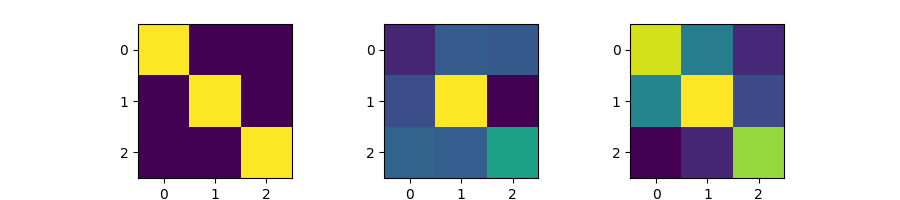

In [12]:
n = len(states)
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(n * 3, 2))
# plot matrices from left to right
for i in range(n):
    axs[i].imshow(states[i])

In [13]:
# uncomment and run this if there are too many plots open
# "Figure x" at the top of the current figure means there are x plots open;
# the notebook might complain once x >= 20

# for _ in jnp.arange(30):
#     plt.close()

Note: below this is mainly for debugging purposes... potentially remove and/or
reuse some of the visualizations.

In [ ]:
# run init_network / init_layer
key = random.PRNGKey(0)
key, subkey = random.split(key)
network = init_model(subkey, [10, 5, 5, 10])
for x in network:
    print(x[0].shape)

In [ ]:
# run predict
t = 3
x = jnp.eye(3)
xt = jnp.append(x.flatten(), t)
# predict(network, xt)

In [ ]:
# example usage of reverse_diffuse_with 
# run forward_diffuse and reverse_diffuse
reverse_diffuse = reverse_diffuse_with(lambda x, t: x)

%timeit forward_diffuse(random.PRNGKey(0), jnp.eye(3), jnp.array([0.1, 0.1, 0.1]))
%timeit reverse_diffuse(random.PRNGKey(0), jnp.eye(3), jnp.array([0.1, 0.1, 0.1]))

In [ ]:
# for visualizing forward and reverse diffusion
n = 4
x = jnp.eye(3)
var_schedule = jnp.array([0.1, 0.2, 0.5])

In [ ]:
# forward diffusion
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 2))
axs[0].imshow(x)
for t in jnp.arange(1, n):
    key, subkey = random.split(key)
    state = forward_diffuse(subkey, x, int(t), var_schedule)
    axs[t].imshow(state)

In [ ]:
print(state)
plt.close()

In [ ]:
# reverse diffusion
x = state
_, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 2))
axs[0].imshow(x)
for t in jnp.arange(1, n):
    key, subkey = random.split(key)
    axs[t].imshow(reverse_diffuse(subkey, x, int(t), var_schedule))

In [ ]:
# run kl divergence
kl_divergence = kl_divergence_with(lambda x, t: x)
kl_divergence(jnp.zeros((3, 3)), jnp.ones((3, 3)), 3, jnp.array([0.5, 0.5, 0.5]))